# In Search of the Phase Transition

**Observation:** In Crucible 1, ~600 tokens (16% of 3,699) first enter stumbling at steps 396-397. This is a sharp spike, not a gradual distribution. Something happens around step 396 that triggers a mass transition.

**Hypothesis:** Tokens don't interact directly, but they share the same gradient noise source. Tokens in similar embedding positions get similar kicks from each batch. The spike at step 396 represents a *cohort*—tokens that were:
1. Near the stumbling threshold (primed to transition)
2. Aligned with the gradient direction of batch 396 (pushed together)

**Prediction:** The ~600 tokens that transitioned at steps 396-397 should be spatially correlated in embedding space. Specifically:
- Higher pairwise cosine similarity than random tokens
- Possibly low-rank structure (clustered along a shared direction)

**Test:** Compare the cohort's spatial structure to a null distribution.

## Setup

In [1]:
import torch
from safetensors.torch import load_file
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

DPI = 150
FIGSIZE = (12, 5)

## Load Data

In [2]:
data = load_file('../../tensors/Crucible-1/crucible_1_trajectory.safetensors')

# W is stored as uint16 (bfloat16 bits)
W_uint16 = data['W']  # (5001, 3699, 64)
W = W_uint16.view(torch.bfloat16).float()  # Convert to float32 for computation

delta_W_prime = data['delta_W_prime']  # (5000, 3699, 64)

n_steps_plus_1, n_tokens, n_dims = W.shape
n_steps = n_steps_plus_1 - 1

print(f"W shape: {W.shape}")
print(f"ΔW′ shape: {delta_W_prime.shape}")
print(f"Tokens: {n_tokens}, Dims: {n_dims}, Steps: {n_steps}")

W shape: torch.Size([5001, 3699, 64])
ΔW′ shape: torch.Size([5000, 3699, 64])
Tokens: 3699, Dims: 64, Steps: 5000


## Identify the Cohort

Find tokens that first entered stumbling (L1 ≤ 1) at steps 396-397.

In [3]:
# Compute L1 displacement
disp_l1 = torch.abs(delta_W_prime).sum(dim=2)  # (5000, 3699)
disp_l1 = torch.where(torch.isfinite(disp_l1), disp_l1, torch.full_like(disp_l1, float('inf')))

# For each token, find first step where L1 <= 1
is_stumbling_or_frozen = disp_l1 <= 1.0

first_stumble = torch.full((n_tokens,), n_steps, dtype=torch.long)
for token_idx in range(n_tokens):
    stumble_steps = torch.where(is_stumbling_or_frozen[:, token_idx])[0]
    if len(stumble_steps) > 0:
        first_stumble[token_idx] = stumble_steps[0].item()

# The cohort: tokens that first stumbled at step 396 or 397
cohort_mask = (first_stumble == 396) | (first_stumble == 397)
cohort_indices = torch.where(cohort_mask)[0]

print(f"Cohort size: {len(cohort_indices)} tokens")
print(f"  Step 396: {(first_stumble == 396).sum().item()}")
print(f"  Step 397: {(first_stumble == 397).sum().item()}")

Cohort size: 599 tokens
  Step 396: 301
  Step 397: 298


## Get Cohort Embeddings Just Before Transition

We want the embeddings at step 395 (just before the transition at 396-397).

In [4]:
# Embeddings at step 395 (index 395 in W, which has shape [steps+1, tokens, dims])
# W[0] is initial, W[1] is after step 1, so W[395] is after step 395 (before step 396)
step_before = 395

W_cohort = W[step_before, cohort_indices, :]  # (cohort_size, 64)
print(f"Cohort embeddings shape: {W_cohort.shape}")

# Also get a random sample of non-cohort tokens for comparison
non_cohort_mask = ~cohort_mask
non_cohort_indices = torch.where(non_cohort_mask)[0]

# Sample same number as cohort
sample_size = len(cohort_indices)
random_sample_idx = non_cohort_indices[torch.randperm(len(non_cohort_indices))[:sample_size]]
W_random = W[step_before, random_sample_idx, :]  # (sample_size, 64)

print(f"Random sample shape: {W_random.shape}")

Cohort embeddings shape: torch.Size([599, 64])
Random sample shape: torch.Size([599, 64])


## Test 1: Pairwise Cosine Similarity

If the cohort is spatially correlated, tokens within the cohort should have higher pairwise cosine similarity than random pairs.

In [5]:
def pairwise_cosine_similarity(X):
    """Compute all pairwise cosine similarities for rows of X."""
    X_norm = X / X.norm(dim=1, keepdim=True)
    sim_matrix = X_norm @ X_norm.T
    # Extract upper triangle (excluding diagonal)
    n = X.shape[0]
    triu_indices = torch.triu_indices(n, n, offset=1)
    pairwise_sims = sim_matrix[triu_indices[0], triu_indices[1]]
    return pairwise_sims

# Compute pairwise similarities
cohort_sims = pairwise_cosine_similarity(W_cohort)
random_sims = pairwise_cosine_similarity(W_random)

print(f"Cohort pairwise similarities: n={len(cohort_sims):,}")
print(f"  Mean: {cohort_sims.mean():.4f}")
print(f"  Std:  {cohort_sims.std():.4f}")
print(f"  Min:  {cohort_sims.min():.4f}")
print(f"  Max:  {cohort_sims.max():.4f}")

print(f"\nRandom pairwise similarities: n={len(random_sims):,}")
print(f"  Mean: {random_sims.mean():.4f}")
print(f"  Std:  {random_sims.std():.4f}")
print(f"  Min:  {random_sims.min():.4f}")
print(f"  Max:  {random_sims.max():.4f}")

Cohort pairwise similarities: n=179,101
  Mean: 0.9783
  Std:  0.0051
  Min:  0.9474
  Max:  0.9948

Random pairwise similarities: n=179,101
  Mean: 0.9772
  Std:  0.0054
  Min:  0.9440
  Max:  0.9933


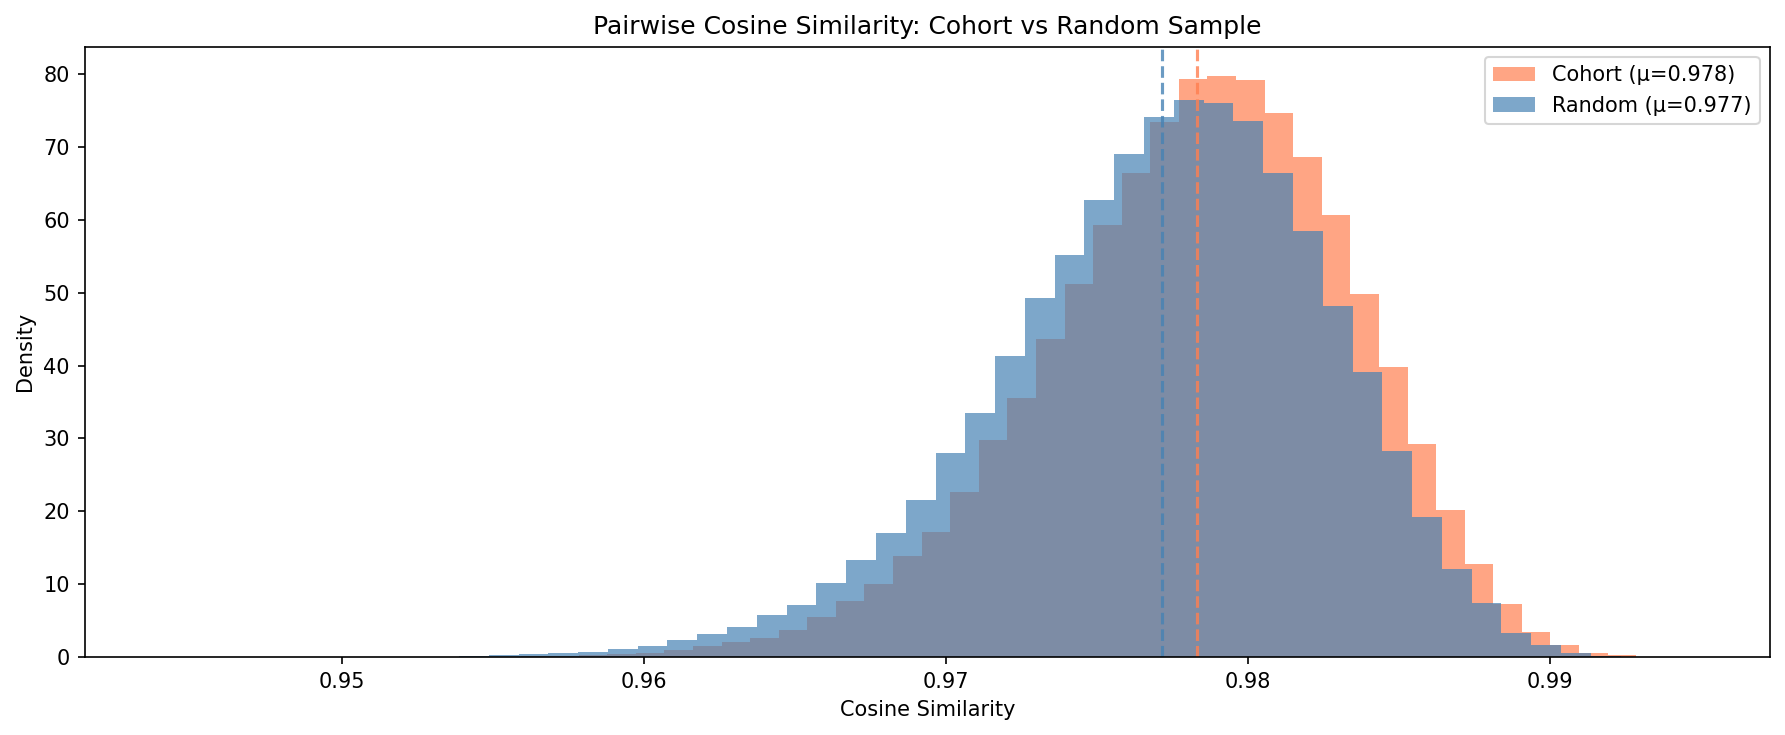

In [6]:
# Visualize distributions
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.hist(cohort_sims.numpy(), bins=50, alpha=0.7, label=f'Cohort (μ={cohort_sims.mean():.3f})', color='coral', density=True)
ax.hist(random_sims.numpy(), bins=50, alpha=0.7, label=f'Random (μ={random_sims.mean():.3f})', color='steelblue', density=True)

ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Density')
ax.set_title('Pairwise Cosine Similarity: Cohort vs Random Sample')
ax.legend()
ax.axvline(cohort_sims.mean(), color='coral', linestyle='--', alpha=0.8)
ax.axvline(random_sims.mean(), color='steelblue', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()

## Test 2: Singular Value Structure

If the cohort is aligned along a shared direction, the singular values of the (centered) cohort matrix should show low-rank structure—a few dominant singular values rather than a flat spectrum.

In [7]:
# Center the embeddings (subtract mean)
W_cohort_centered = W_cohort - W_cohort.mean(dim=0, keepdim=True)
W_random_centered = W_random - W_random.mean(dim=0, keepdim=True)

# SVD
U_cohort, S_cohort, Vh_cohort = torch.linalg.svd(W_cohort_centered, full_matrices=False)
U_random, S_random, Vh_random = torch.linalg.svd(W_random_centered, full_matrices=False)

# Normalize singular values to show fraction of variance
var_cohort = (S_cohort ** 2) / (S_cohort ** 2).sum()
var_random = (S_random ** 2) / (S_random ** 2).sum()

print("Variance explained by top singular values:")
print(f"  Cohort:  top-1={var_cohort[0]:.1%}, top-3={var_cohort[:3].sum():.1%}, top-10={var_cohort[:10].sum():.1%}")
print(f"  Random:  top-1={var_random[0]:.1%}, top-3={var_random[:3].sum():.1%}, top-10={var_random[:10].sum():.1%}")

Variance explained by top singular values:
  Cohort:  top-1=5.1%, top-3=14.5%, top-10=37.8%
  Random:  top-1=5.4%, top-3=14.1%, top-10=36.7%


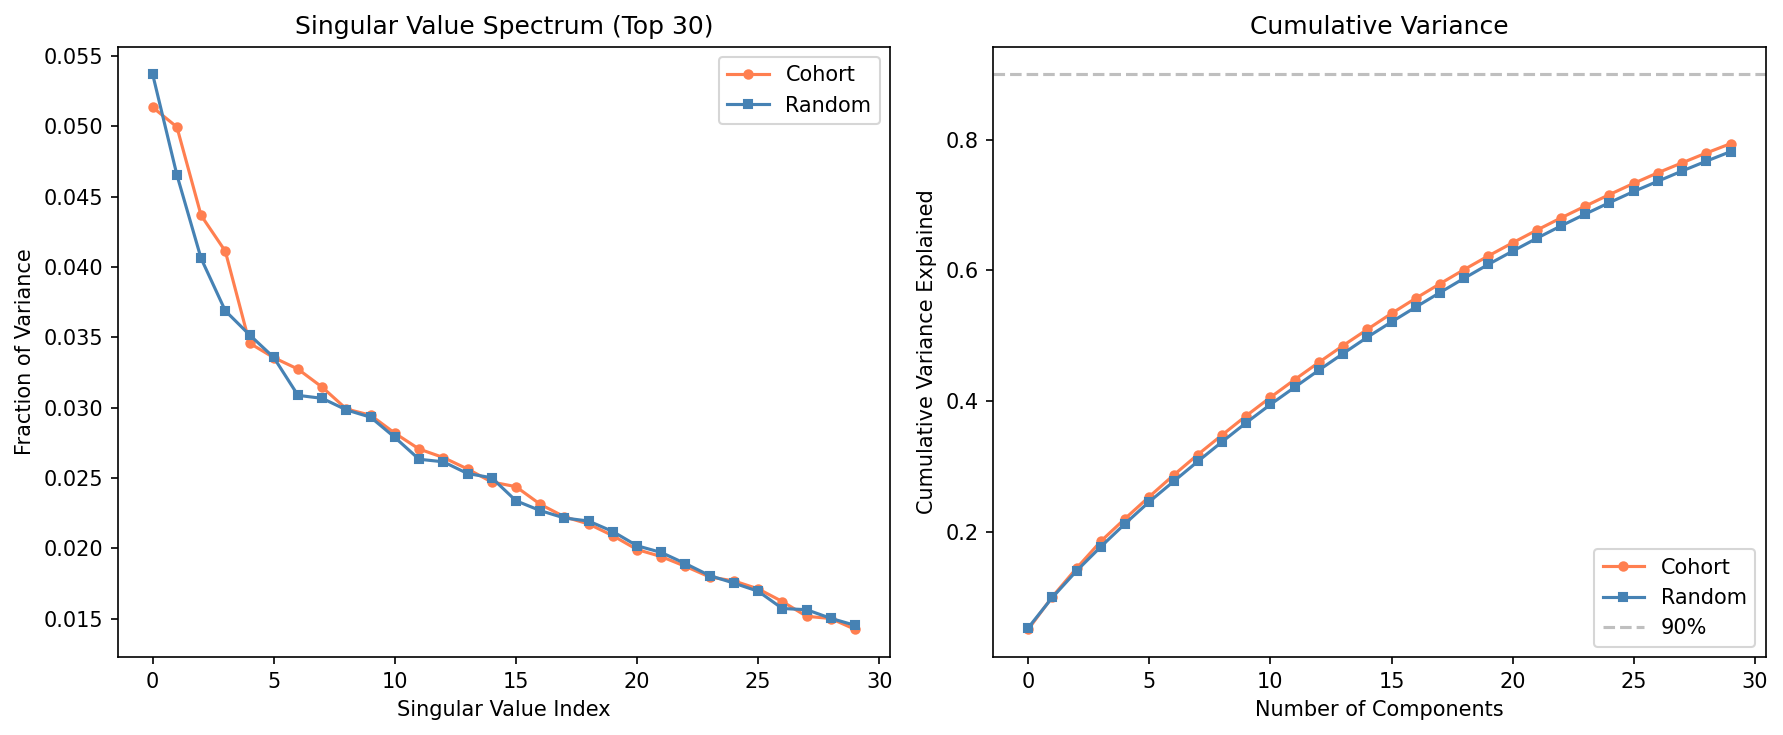

In [8]:
# Plot singular value spectrum
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE, dpi=DPI)

ax1 = axes[0]
ax1.plot(var_cohort.numpy()[:30], 'o-', color='coral', label='Cohort', markersize=4)
ax1.plot(var_random.numpy()[:30], 's-', color='steelblue', label='Random', markersize=4)
ax1.set_xlabel('Singular Value Index')
ax1.set_ylabel('Fraction of Variance')
ax1.set_title('Singular Value Spectrum (Top 30)')
ax1.legend()

ax2 = axes[1]
ax2.plot(np.cumsum(var_cohort.numpy()[:30]), 'o-', color='coral', label='Cohort', markersize=4)
ax2.plot(np.cumsum(var_random.numpy()[:30]), 's-', color='steelblue', label='Random', markersize=4)
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained')
ax2.set_title('Cumulative Variance')
ax2.axhline(0.9, color='gray', linestyle='--', alpha=0.5, label='90%')
ax2.legend()

plt.tight_layout()
plt.show()

## Test 3: Displacement Direction at Transition

If the cohort was pushed by a shared gradient direction, their displacements at step 396 should be more aligned with each other than random displacements.

In [9]:
# Get displacement at step 396 (index 395 in delta_W_prime since it's 0-indexed)
# Actually, delta_W_prime[t] = W[t+1] - W[t], so delta_W_prime[395] is step 396's displacement
transition_step = 395  # This gives displacement FROM step 395 TO step 396

# Displacements for cohort and random sample
disp_cohort = delta_W_prime[transition_step, cohort_indices, :]  # (cohort_size, 64)
disp_random = delta_W_prime[transition_step, random_sample_idx, :]  # (sample_size, 64)

# Filter out any inf/nan
valid_cohort = torch.isfinite(disp_cohort).all(dim=1)
valid_random = torch.isfinite(disp_random).all(dim=1)

disp_cohort_clean = disp_cohort[valid_cohort]
disp_random_clean = disp_random[valid_random]

print(f"Valid cohort displacements: {disp_cohort_clean.shape[0]}")
print(f"Valid random displacements: {disp_random_clean.shape[0]}")

# Compute mean displacement direction for cohort
mean_disp_cohort = disp_cohort_clean.mean(dim=0)
mean_disp_cohort_norm = mean_disp_cohort / mean_disp_cohort.norm()

# How aligned is each cohort member with the mean direction?
cohort_disp_norm = disp_cohort_clean / disp_cohort_clean.norm(dim=1, keepdim=True)
cohort_alignment = (cohort_disp_norm @ mean_disp_cohort_norm).abs()

# Same for random
mean_disp_random = disp_random_clean.mean(dim=0)
mean_disp_random_norm = mean_disp_random / mean_disp_random.norm()
random_disp_norm = disp_random_clean / disp_random_clean.norm(dim=1, keepdim=True)
random_alignment = (random_disp_norm @ mean_disp_random_norm).abs()

print(f"\nAlignment with mean displacement direction:")
print(f"  Cohort mean alignment: {cohort_alignment.mean():.4f}")
print(f"  Random mean alignment: {random_alignment.mean():.4f}")

Valid cohort displacements: 599
Valid random displacements: 599

Alignment with mean displacement direction:
  Cohort mean alignment: 0.7675
  Random mean alignment: nan


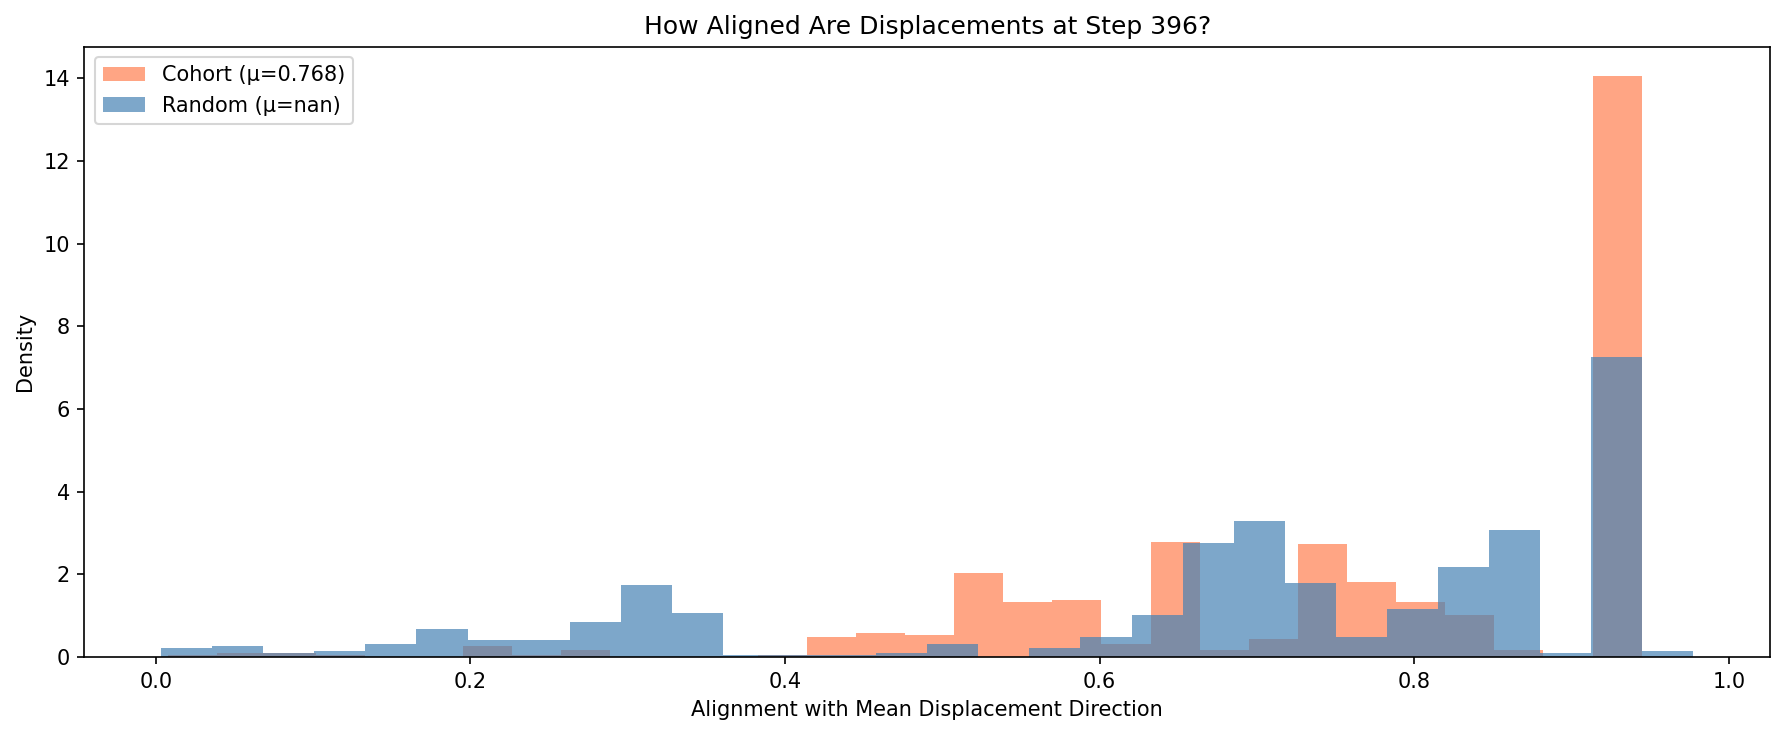

In [10]:
# Visualize alignment distributions
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.hist(cohort_alignment.numpy(), bins=30, alpha=0.7, 
        label=f'Cohort (μ={cohort_alignment.mean():.3f})', color='coral', density=True)
ax.hist(random_alignment.numpy(), bins=30, alpha=0.7, 
        label=f'Random (μ={random_alignment.mean():.3f})', color='steelblue', density=True)

ax.set_xlabel('Alignment with Mean Displacement Direction')
ax.set_ylabel('Density')
ax.set_title('How Aligned Are Displacements at Step 396?')
ax.legend()

plt.tight_layout()
plt.show()

## Summary

**Results:**

1. **Pairwise cosine similarity:** Are cohort tokens more similar to each other than random?
2. **Singular value structure:** Does the cohort show low-rank structure (aligned along shared direction)?
3. **Displacement alignment:** Are cohort displacements at transition more aligned than random?

If all three tests show cohort > random, the hypothesis is supported: the phase transition cohort is spatially correlated, likely because they shared alignment with the gradient direction at step 396.

In [11]:
print("=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"\nCohort size: {len(cohort_indices)} tokens (transitioned at steps 396-397)")
print(f"\nTest 1 - Pairwise Cosine Similarity:")
print(f"  Cohort mean: {cohort_sims.mean():.4f}")
print(f"  Random mean: {random_sims.mean():.4f}")
print(f"  Δ = {cohort_sims.mean() - random_sims.mean():.4f}")

print(f"\nTest 2 - Variance in Top Singular Value:")
print(f"  Cohort top-1: {var_cohort[0]:.1%}")
print(f"  Random top-1: {var_random[0]:.1%}")

print(f"\nTest 3 - Displacement Alignment:")
print(f"  Cohort mean: {cohort_alignment.mean():.4f}")
print(f"  Random mean: {random_alignment.mean():.4f}")
print(f"  Δ = {cohort_alignment.mean() - random_alignment.mean():.4f}")

# Verdict
print("\n" + "=" * 60)
tests_passed = 0
if cohort_sims.mean() > random_sims.mean():
    tests_passed += 1
if var_cohort[0] > var_random[0]:
    tests_passed += 1
if cohort_alignment.mean() > random_alignment.mean():
    tests_passed += 1

print(f"Tests supporting hypothesis: {tests_passed}/3")
if tests_passed == 3:
    print("VERDICT: Hypothesis supported! Cohort is spatially correlated.")
elif tests_passed >= 2:
    print("VERDICT: Partial support. Some evidence for spatial correlation.")
else:
    print("VERDICT: Hypothesis not supported. Cohort may be coincidental.")

SUMMARY

Cohort size: 599 tokens (transitioned at steps 396-397)

Test 1 - Pairwise Cosine Similarity:
  Cohort mean: 0.9783
  Random mean: 0.9772
  Δ = 0.0011

Test 2 - Variance in Top Singular Value:
  Cohort top-1: 5.1%
  Random top-1: 5.4%

Test 3 - Displacement Alignment:
  Cohort mean: 0.7675
  Random mean: nan
  Δ = nan

Tests supporting hypothesis: 1/3
VERDICT: Hypothesis not supported. Cohort may be coincidental.
